In [ ]:
from datasets import load_dataset, DatasetDict
from transformers import AutoModelForCausalLM, AutoTokenizer
from white_box.data import chunk_and_tokenize, silence_datasets_messages
import torch as th

def load_stuff(name):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).cuda()
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = load_dataset("wikitext", "wikitext-103-v1")
    assert isinstance(dataset, DatasetDict)
    silence_datasets_messages()

    dataset = chunk_and_tokenize(dataset, tokenizer)
    return model, tokenizer, dataset

gpt2, gpt2_tokenizer, gpt2_data = load_stuff("gpt2")
neo, neo_tokenizer, neo_data = load_stuff("EleutherAI/gpt-neo-125M")

In [8]:
from accelerate.utils import send_to_device
from white_box.model_surgery import delete_layers
import torch as th

def run_layer_ablation(model, data):
    ablations = [[l] for l in range(model.config.num_hidden_layers)]
    ablations += [[]]
    losses = []

    for ab in ablations:
        with delete_layers(model, ab), th.no_grad():
            loss = 0.0
            model.eval()

            N = len(data["test"])
            for i in range(N):
                # Hack because Pythia models require a batch dimension
                item = send_to_device(data["test"][i:i + 1], "cuda:0")
                loss = model(**item, labels=item['input_ids']).loss.squeeze()
                loss = i / (i + 1) * loss + 1 / (i + 1) * loss

            print(loss * 0.29335)
            losses.append(loss.cpu() * 0.29335)

    return losses

In [ ]:
gpt2_losses = run_layer_ablation(gpt2, gpt2_data)
neo_losses = run_layer_ablation(neo, neo_data)

In [16]:
import matplotlib.pyplot as plt

def plot_losses(losses, name, tick_step = 1):
    plt.plot(losses[:-1], marker="o", label=f"{name} ablated")
    plt.hlines(
        losses[-1], 0, len(losses) - 1,
        linestyles="dashed", label=f"{name} baseline"
    )
    plt.xlabel("Layer ablated")
    plt.xticks(range(0, len(losses) - 1, tick_step))
    plt.ylabel("Wikitext bits per byte")

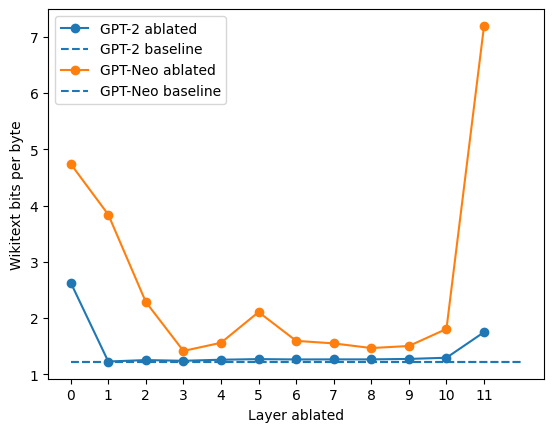

In [17]:
plot_losses(gpt2_losses, "GPT-2")
plot_losses(neo_losses, "GPT-Neo")
plt.legend()

In [ ]:
# Save memory
del gpt2, neo, gpt2_data, neo_data

pythia125m, pythia125m_tokenizer, pythia125m_data = load_stuff("EleutherAI/pythia-125m")
pythia7b, pythia7b_tokenizer, pythia7b_data = load_stuff("EleutherAI/pythia-6.7b")

In [9]:
pythia125_losses = run_layer_ablation(pythia125m, pythia125m_data)
pythia7b_losses = run_layer_ablation(pythia7b, pythia7b_data)

tensor(2.7539, device='cuda:0', dtype=torch.float16)
tensor(1.3926, device='cuda:0', dtype=torch.float16)
tensor(1.5811, device='cuda:0', dtype=torch.float16)
tensor(1.6719, device='cuda:0', dtype=torch.float16)
tensor(1.3789, device='cuda:0', dtype=torch.float16)
tensor(1.3477, device='cuda:0', dtype=torch.float16)
tensor(1.4092, device='cuda:0', dtype=torch.float16)
tensor(1.3105, device='cuda:0', dtype=torch.float16)
tensor(1.4023, device='cuda:0', dtype=torch.float16)
tensor(1.3682, device='cuda:0', dtype=torch.float16)
tensor(1.3389, device='cuda:0', dtype=torch.float16)
tensor(1.5195, device='cuda:0', dtype=torch.float16)
tensor(1.2119, device='cuda:0', dtype=torch.float16)
tensor(2.8438, device='cuda:0', dtype=torch.float16)
tensor(0.9609, device='cuda:0', dtype=torch.float16)
tensor(0.9517, device='cuda:0', dtype=torch.float16)
tensor(1.0205, device='cuda:0', dtype=torch.float16)
tensor(0.9805, device='cuda:0', dtype=torch.float16)
tensor(1.0537, device='cuda:0', dtype=torch.fl

Text(0.5, 1.0, 'EleutherAI Pythia 6.7B Robustness to Layer Ablation')

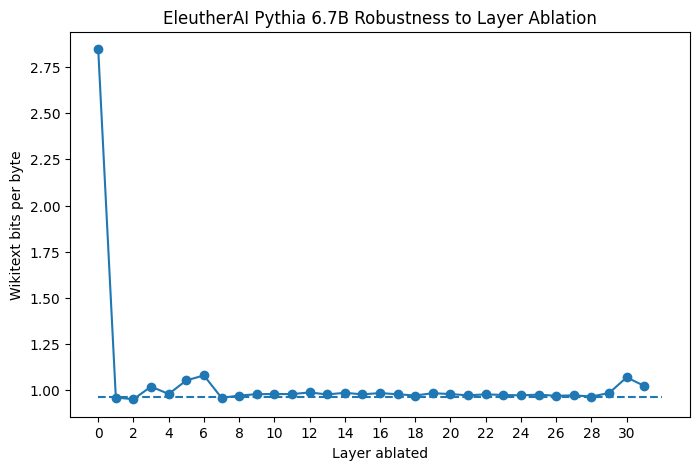

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plot_losses(pythia7b_losses, "Pythia 6.7B", 2)
plt.title("EleutherAI Pythia 6.7B Robustness to Layer Ablation")